In [1]:
import numpy as np
from nudging.simulation.multidata import generate_multi_dataset
from sklearn.linear_model import BayesianRidge, LogisticRegression
from nudging.model.regressor import BaseBiRegressor
from nudging.model.probmodel import ProbModel
from nudging.cate import get_cate_correlations
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
np.random.seed(9817274)
datasets = generate_multi_dataset(100)

In [3]:
model_bayes = BaseBiRegressor(BayesianRidge())
model_proba = ProbModel(LogisticRegression())

In [4]:
model_bayes.predictors = list(datasets[0].data["X"])
model_proba.predictors = ["age", "gender"]
model_bayes.predictors = ["age", "gender"]

In [5]:
%%time
all_corr_bayes = []
for data in tqdm(datasets):
    corr_bayes = np.mean(get_cate_correlations(model_bayes, data, data.truth["cate"]))
    all_corr_bayes.append(corr_bayes)

100%|██████████| 100/100 [01:17<00:00,  1.29it/s]

CPU times: user 1min 17s, sys: 1.4 s, total: 1min 18s
Wall time: 1min 17s


In [6]:
%%time
all_corr_proba = []
for data in tqdm(datasets):
    corr_proba = np.mean(get_cate_correlations(model_proba, data, data.truth["cate"]))
    all_corr_proba.append(corr_proba)

100%|██████████| 100/100 [03:58<00:00,  2.38s/it]

CPU times: user 22min 21s, sys: 1h 37min 29s, total: 1h 59min 51s
Wall time: 3min 58s


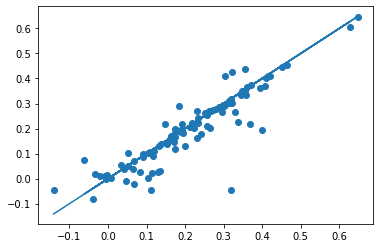

In [7]:
plt.scatter(all_corr_bayes, all_corr_proba)
plt.plot(all_corr_bayes, all_corr_bayes)
plt.show()

In [8]:
np.mean(all_corr_bayes), np.mean(all_corr_proba)

(0.21309853167915194, 0.1985677050652557)

In [9]:
def plot_correlations(attr, correlations):
    x = np.array([data.truth[attr] for data in datasets])
    xcor = spearmanr(x, correlations).correlation
    plt.scatter(x, correlations)
    plt.title(xcor)
    plt.show()

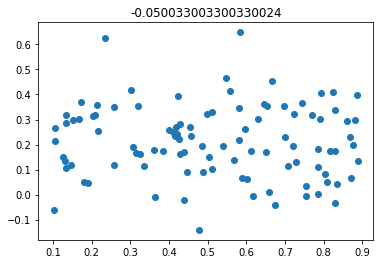

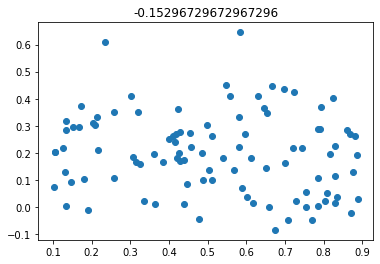

In [10]:
plot_correlations("noise_frac", all_corr_bayes)
plot_correlations("noise_frac", all_corr_proba)

In [11]:
plot_correlations("noise_frac")

TypeError: plot_correlations() missing 1 required positional argument: 'correlations'

In [ ]:
plot_correlations("n_samples")

In [ ]:
plot_correlations("control_unique")

In [ ]:
plot_correlations("control_precision")